# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price (Adjusted Close) and make a trading recommendation for the user. 

The input features are:
- Open 
- Close
- Low
- High

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithm will be used for prediction:
- LSTM (Long Short-Term Memory)

This is a popular algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

The final program on Github.com (https://github.com/maximkiesel1/Stock_Market_Prediction)  can be used for all stocks.

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [Training/Validation: LSTM](#tlstm)
#### 3. [Comparison Stock Types](#comparison)
#### 4. [Prediction: LSTM](#plstm)

In [26]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.compat.v1 as tf

import pickle

import absl.logging
import logging

import random

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

At first, I load the data from a database. After that, I define the new features and integrate them. Lastly, I split the data in training, validation, and test data. Also, the data will be transformed in a fitted form for the LSTM algorithm.

In [544]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    Transform the data in arrays
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    data - (dict) transformed dfs for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    
    data = {}
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        # positioning for the target variable on the last column position (for easy finding)
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        data[name] = df
        
    return data

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.

- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.

- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.

- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.

- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.

- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.

- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

Later on, I will test the model performance with the original 6 features and the performance with the new 11 features. 

In [547]:
def feat_eng(data):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    data - (dict) stock dfs with the new features
    '''
    
    # create empty dict for the new dfs with the new features
    data_ =  {}
    
    for name in data:
        
        # define the dfs from the dict
        df = data[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(df['Adj Close'], window=20)
        df['EMA'] = ta.trend.ema_indicator(df['Adj Close'], window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close= df['Adj Close'], window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        
        # put the target variable on the place of the last column to find it later
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        # add the df in the dict
        data[name] = df

    return data

The next function splits the data, transform it, that it can be used be the LSTM algorithm and do a Z-Score normalization. 

In [558]:
def data_split(df, window_size):
    '''
    Splitting of the datasets in the dictionaries in train, validation, and test (60%, 20%, 20%).
    Transform the date that it can used in the lstm algorithm.
    Z-Score normalization of the data
    
    INPUT 
    df - (dataframe) Stock dataframe
    windows_size - (int) Number of how far back the program should look at the previous data
      
    OUTPUT
    Xs_train - (dict) Splits training data of the input features
    Xs_val - (dict) Split validation data of the input features
    Xs_test - (dict) Split test data of the input features
    test_mean - Mean of the adjusted close in the X test data
    test_std - Standard deviation of the adjusted close in the X test data
    ys_train - (dict) Split training data of the output feature
    ys_val - (dict) Split validation data of the output feature
    ys_test - (dict) Split test data of the output feature
    test_y_mean - mean of the adjusted close in the y test data
    test_std - Standard deviation of the adjusted close in the y test data
    '''
    
    array = np.array(df)
    
    X, y = [], []
    
    for i in range(len(array)-window_size):
        X.append(array[i:i+window_size])
        y.append(array[i+window_size])
        
    X = np.array(X)
    y = np.array(y)
    
    # Split the data into training, validation, and testing sets
    n_samples = len(X)
    train_size = int(0.6 * n_samples)
    val_size = int(0.2 * n_samples)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
    
    # Standardize the features in X_train, X_val, and X_test
    for i in range(X_train.shape[-1]):
        train_mean = np.mean(X_train[:, :, i])
        train_std = np.std(X_train[:, :, i])
        val_mean = np.mean(X_val[:, :, i])
        val_std = np.std(X_val[:, :, i])
        test_mean = np.mean(X_test[:, :, i])
        test_std = np.std(X_test[:, :, i])
        
        X_train[:, :, i] = (X_train[:, :, i] - train_mean) / train_std
        X_val[:, :, i] = (X_val[:, :, i] - val_mean) / val_std
        X_test[:, :, i] = (X_test[:, :, i] - test_mean) / test_std
        
        train_y_mean = np.mean(y_train[:,i])
        train_y_std = np.std(y_train[:,i])
        val_y_mean = np.mean(y_val[:,i])
        val_y_std = np.std(y_val[:,i])
        test_y_mean = np.mean(y_test[:,i])
        test_y_std = np.std(y_test[:,i])
        
        y_train[:,i] = (y_train[:,i] - train_y_mean) / train_y_std
        y_val[:, i] = (y_val[:,i] - val_y_mean) / val_y_std
        y_test[:, i] = (y_test[:,i] - test_y_mean) / test_y_std
    
    # the last column (adjusted close) of the X/y test mean and std arrays will be returned (for back transformation)
    return X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std


## <a class="anchor" id="tlstm"> 2. Training/Validation: LSTM </a>

Now I will define a very popular algorithm for time series. It´s the Long Short-Term Memory (LSTM). A Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to model sequential data by retaining and selectively forgetting previous information. It achieves this by using a memory cell, an input gate, an output gate, and a forget gate to regulate the flow of information through the cell. 

At first, I define the algorithm for one stock ('BMW.DE') and see if it can perform the 5% tolerance with 6 existing features.

In [559]:
# load the data with 6 features
data = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

In [560]:
def train_model(data, loops):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    data - (dict) Stock dfs with the new features
    loop - (int) Numbers of loops with randomized model parameter
      
    OUTPUT
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    '''
    
    # define empty dict
    best_model = {}
    
    # define selection of parameters
    params = {
    'window_size': [4, 8, 12, 20],
    'lstm_units': [16, 32, 64, 128],
    'dense_units': [16, 32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    
    # iterate through the stock names
    for name in data:
        
        # info printing
        print('Trained Stock: {}'.format(name))
        
        best_model[name] = {}
        
        # select the arrays
        df = data[name]
        
        # iterate through 
        for i in range(1,loops+1):
            
            # info printing
            print('Parameter run: {}'.format(i))
        
            random_params = {key: random.choice(values) for key, values in params.items()}
    
            # info printing
            print('Parameters: {}'.format(random_params))
    
            X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std = data_split(df, random_params['window_size'])

            # define the model for the stock JNJ
            model = Sequential()
            model.add(InputLayer((random_params['window_size'], X_train.shape[-1]))) # the first parameter is always the window size, the second the number of features
            model.add(LSTM(random_params['lstm_units']))
            model.add(Dense(random_params['dense_units'], 'relu'))
            model.add(Dense(X_train.shape[-1], 'linear')) # output of 17 features
            model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()])
    
            # create a model checkpoint for the best model
            cp = ModelCheckpoint('model', save_best_only=True, verbose=0)
            
            # fitting the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp], verbose=0)
    
            # load the best model
            model = load_model('model')
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if i == 1:
                
                best_model[name]['model'] = model
                best_model[name]['mse'] = best_mse
                best_model[name]['paramter'] = random_params
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_model[name]['mse'] > best_mse:
                    
                    best_model[name]['model'] = model
                    best_model[name]['mse'] = best_mse
                    best_model[name]['paramter'] = random_params
                
                else:
                    
                    continue
                    
        break # break the loop to just train a model for the stock 'BMW.DE'
        
    return best_model

In [ ]:
# train the model with 6 features
best_model = train_model(data, 10)

Trained Stock: BMW.DE
Parameter run: 1
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 32, 'learning_rate': 0.1}


2023-05-05 22:05:08.734474: W tensorflow/c/c_api.cc:300] Operation '{name:'training_428/Adam/dense_459/kernel/m/Assign' id:260648 op device:{requested: '', assigned: ''} def:{{{node training_428/Adam/dense_459/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_428/Adam/dense_459/kernel/m, training_428/Adam/dense_459/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-05 22:05:15.548073: W tensorflow/c/c_api.cc:300] Ope

Parameter run: 2
Parameters: {'window_size': 20, 'lstm_units': 64, 'dense_units': 32, 'learning_rate': 0.001}


2023-05-05 22:06:55.390226: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_230/lstm_cell_442/recurrent_kernel/Assign' id:261240 op device:{requested: '', assigned: ''} def:{{{node lstm_230/lstm_cell_442/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_230/lstm_cell_442/recurrent_kernel, lstm_230/lstm_cell_442/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:07:02.368757: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_438/mul' id:261453 op device:{requested: '', assigned: ''} def:{{{node loss_438/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_438/mul/x, loss_438/dense_461_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 3
Parameters: {'window_size': 8, 'lstm_units': 16, 'dense_units': 64, 'learning_rate': 0.0001}


2023-05-05 22:09:00.983316: W tensorflow/c/c_api.cc:300] Operation '{name:'lstm_231/lstm_cell_444/recurrent_kernel/Assign' id:262453 op device:{requested: '', assigned: ''} def:{{{node lstm_231/lstm_cell_444/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_231/lstm_cell_444/recurrent_kernel, lstm_231/lstm_cell_444/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:09:07.922649: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_440/mul' id:262666 op device:{requested: '', assigned: ''} def:{{{node loss_440/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_440/mul/x, loss_440/dense_463_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will h

Parameter run: 4
Parameters: {'window_size': 8, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.001}


2023-05-05 22:10:58.872421: W tensorflow/c/c_api.cc:300] Operation '{name:'training_434/Adam/decay/Assign' id:264226 op device:{requested: '', assigned: ''} def:{{{node training_434/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_434/Adam/decay, training_434/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:11:05.801655: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_442/mul' id:263871 op device:{requested: '', assigned: ''} def:{{{node loss_442/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_442/mul/x, loss_442/dense_465_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

Parameter run: 5
Parameters: {'window_size': 12, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 0.01}


2023-05-05 22:12:45.035905: W tensorflow/c/c_api.cc:300] Operation '{name:'training_436/Adam/dense_467/bias/m/Assign' id:265477 op device:{requested: '', assigned: ''} def:{{{node training_436/Adam/dense_467/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_436/Adam/dense_467/bias/m, training_436/Adam/dense_467/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:12:52.049795: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_444/mul' id:265076 op device:{requested: '', assigned: ''} def:{{{node loss_444/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_444/mul/x, loss_444/dense_467_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

Parameter run: 6
Parameters: {'window_size': 4, 'lstm_units': 64, 'dense_units': 16, 'learning_rate': 0.0001}


2023-05-05 22:14:25.477799: W tensorflow/c/c_api.cc:300] Operation '{name:'training_438/Adam/dense_468/kernel/v/Assign' id:266716 op device:{requested: '', assigned: ''} def:{{{node training_438/Adam/dense_468/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_438/Adam/dense_468/kernel/v, training_438/Adam/dense_468/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-05 22:14:30.213939: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_446/mul' id:266289 op device:{requested: '', assigned: ''} def:{{{node loss_446/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_446/mul/x, loss_446/dense_469_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

In [ ]:
# show the best model components 
best_model

In this step, I will visualize the data to how it fits.

In [ ]:
def model_validation(data, best_model):
    
    for name in best_model:
        
        X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std  = data_split(data[name], best_model[name]['paramter']['window_size'])
        
        # make prediction
        test_predictions = best_model[name]['model'].predict(np.array(X_test))
        
        # select the Adjusted Close for prediction (last column)
        test_predictions_ = test_predictions[:,-1].tolist()
        
        # back transformation for X data  from the normalization 
        transfom_X = ((np.array(test_predictions_)*test_std) + test_mean).tolist()

        # select the Adjusted Close for test data (last column)
        y_test_ = y_test[:,-1].tolist()
        
        # back transformation for y data  from the normalization 
        transfom_y = ((np.array(y_test_)*test_y_std) + test_y_mean).tolist()

        # create a dataframe with predicted values and real values
        test_results = pd.DataFrame(data={'Test Predictions':transfom_X, 'Actuals': transfom_y})
        
        # calculate the difference between prediction and ground truth
        test_results['diff'] = test_results['Test Predictions']-test_results['Actuals']
        
        # calculate the percentage difference between prediction and ground truth
        test_results['diff%'] = (test_results['diff'] / test_results['Actuals'])*100
        
        # ploting
        print('######################')
        print(name)
        print('######################')
        
        # show the statistical informations
        print(test_results.describe())

        # plot test and ground truth data
        plt.figure(figsize=(25, 15))
        plt.plot(test_results['Test Predictions'], label='Test Predictions')
        plt.plot(test_results['Actuals'], label='Actuals')
        plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
        plt.ylabel('Adjusted Close')
        plt.xlabel('Timeline')
        plt.legend()
        plt.grid()
        plt.show()
        
        # plot for percentage deviation between predicted and real values in test data 
        plt.figure(figsize=(25, 15))
        plt.plot(test_results.index, test_results['diff%'], color='steelblue', label='Percentage Deviation')
        plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
        plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
        plt.grid()
        plt.legend()
        plt.ylabel('Percentage Deviation[%]')
        plt.xlabel('Timeline')
        plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
        plt.show()
        print('The mean for the percentage deviation in the test data is {}.'.format(abs(np.mean(test_results['diff%']))))
        print('-----------------------------------------')
        
    return None
        
        

In [ ]:
# showing the results of the best model
model_validation(data, best_model)

The result is not bad. Let´s if it can be better with 6 more features.

***Information***: I´m aware, that with a loop of 10 don´t include all parameter constellations. Due to the training time, I decided this loop number. 

In [ ]:
data = feat_eng(data)

In [ ]:
# train the model with 17 features
best_model = train_model(data, 10)

In [ ]:
# show the best model components 
best_model

In [ ]:
model_validation(data, best_model)

## <a class="anchor" id="comparison"> 3. Comparison Stock Types </a>

In this chapter, I will do 20 trainings loops for all stocks and compare the prediction performance on the base of the stock type.

## <a class="anchor" id="plstm"> 4. Prediction: LSTM </a>

In [145]:
data = Xs_test['JNJ'][-1]

predictions_list = []

for i in range(1, 29):  # Wiederholen Sie den Vorgang 10 Mal, um Vorhersagen für die nächsten 10 Zeitschritte zu erhalten
    
    print(i)
    prediction = model1.predict(np.array(data).reshape(1, 10, 17))  # Das Modell erwartet eine Eingabeform von (1, 10, 17)
    predictions_list.append(prediction)
    data = np.vstack((data[1:], prediction))

1
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 11ms/step
3
1/1 [==============================] - 0s 12ms/step
4
1/1 [==============================] - 0s 12ms/step
5
1/1 [==============================] - 0s 12ms/step
6
1/1 [==============================] - 0s 11ms/step
7
1/1 [==============================] - 0s 11ms/step
8
1/1 [==============================] - 0s 12ms/step
9
1/1 [==============================] - 0s 12ms/step
10
1/1 [==============================] - 0s 12ms/step
11
1/1 [==============================] - 0s 12ms/step
12
1/1 [==============================] - 0s 11ms/step
13
1/1 [==============================] - 0s 12ms/step
14
1/1 [==============================] - 0s 12ms/step
15
1/1 [==============================] - 0s 12ms/step
16
1/1 [==============================] - 0s 11ms/step
17
1/1 [==============================] - 0s 12ms/step
18
1/1 [==============================] - 0s 11ms/step
19
1/1 [===========

In [148]:
a = [arr[-1] for arr in data]
b = [arr[-1] for arr in Xs_test['JNJ'][-1]]

In [150]:
a

[0.7531004548072815,
 0.7520443797111511,
 0.7510243058204651,
 0.7500399351119995,
 0.7490900754928589,
 0.748173177242279,
 0.747286319732666,
 0.7464272379875183,
 0.7455933094024658,
 0.7447816133499146]

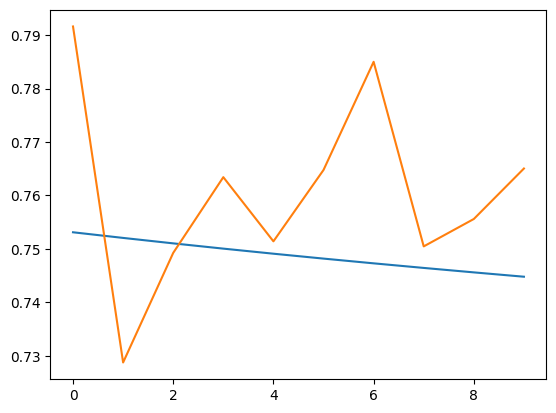

In [151]:
plt.plot(a)
plt.plot(b)

Neuer Plan:
- Jupyter Notebooks fertig machen
- Klassich Daten (nur Stock Namen) eingeben
    - Daten in DB speichern
    - Neues Programm: Visualisierung in einem Neuen Fenster, wenn der Kunde es wünscht
    - Neues Programm: starten für Prediction
        - Daten laden und feature engineering durchführen
        - LTSM trainieren (50 Epochen, inklusiere finden des besten window-fensters)
        - Zukunftswerte predicten: 7, 14, 28 Tage
        - Visualisierung von Status Quo zu Prediction mit Empfehlung
               - Kunden Visualisierung:
                     - Testdaten zeigen in einer Farbe
                     - Zukunftswerte (Kursentwicklung) in einer anderen Farbe
                     - Empfehlung schreiben:
                     - Ist der Wert größer nach 28 Tage: Behalten
                     - kleiner: verkaufen